# Q-learning

Each step is used to update the transition matrixm. The probability distribution in the transition matrix is used to update the Q table. No smoothing via learning rate is needed.

The Q table updating rule is
$$
Q(s, a) = \sum_{s'} p_{s, a \rightarrow s'} (r_{s, a \rightarrow s'} + \max_{a' \in A} Q(s', a')) 
$$

In [3]:
import gym
import numpy as np
import os
import random
import time
from tqdm import tqdm
from collections import defaultdict
from collections import Counter
from IPython.display import clear_output

In [13]:
episode_num = 1000
timeout_step_num = 100

gamma = 0.99
lr = 0.1

# epsilon greedy params
epsilon_min = 0.01
epsilon_decay = 1#0.001

random_play_num = 100

In [24]:
env = gym.make('FrozenLake-v0')

action_space_size = env.action_space.n
obs_space_size = env.observation_space.n
q_table = np.zeros((obs_space_size, action_space_size))
rewards = defaultdict(float)
transits = defaultdict(Counter)


# random play some episodes to fill in transits
def play_n_episodes(n):
    state = env.reset()
    for i in range(n):
        while True:
            action = np.random.choice(action_space_size)
            new_state, reward, done, _ = env.step(action)
            transits[(state, action)][new_state] += 1
            rewards[(state, action, new_state)] = reward
            state = new_state
            if done:
                break


def update_q_table_value_iteration():
    """Update every entry in the q_table"""
    for state in range(obs_space_size):
        for action in range(action_space_size):
            total = sum(transits[(state, action)].values())
            q_value = 0
            for new_state, freq in transits[(state, action)].items():
#                 print(new_state, freq)
                reward = rewards[(state, action, new_state)]
                q_value += (freq / total) * (
                    reward + gamma * np.max(q_table[new_state, :]))
#             print(q_value)
            q_table[state, action] = q_value

    
def get_epsilon(episode_idx):
    epsilon = epsilon_min + (1 - epsilon_min) * np.exp(- epsilon_decay * episode_idx)
#     if episode_idx % 100 == 0:
#         print(episode_idx, epsilon)
    return epsilon


def get_action():
    if np.random.random() > epsilon:
        action = np.argmax(q_table[state, :])
    else:
        action = np.random.choice(action_space_size)
    return action


episodes_rewards = []

for episode_idx in tqdm(range(episode_num)):    
    play_n_episodes(n=random_play_num) # this updates transits and rewards
    current_episode_reward = 0
    state = env.reset()
    epsilon = 0 #get_epsilon(episode_idx)

    for step_idx in range(timeout_step_num):
        action = get_action()
        new_state, reward, done, _ = env.step(action)
        
        # update transits, rewards, q_table
        transits[(state, action)][new_state] += 1
        rewards[(state, action, new_state)] = reward
        update_q_table_value_iteration()

        # prepare next step
        current_episode_reward += reward
        state = new_state
        if done:
            break
    episodes_rewards.append(current_episode_reward)
    
print('****updated q_table****')
print(q_table)

100%|██████████| 1000/1000 [00:41<00:00, 21.15it/s]

****updated q_table****
[[0.51884797 0.5073284  0.50662865 0.50019803]
 [0.3339779  0.33450378 0.29821249 0.4816047 ]
 [0.42747914 0.42078982 0.41747315 0.45532248]
 [0.29720236 0.30106859 0.28503624 0.44214538]
 [0.53472729 0.34196534 0.36029559 0.35083123]
 [0.         0.         0.         0.        ]
 [0.33154806 0.27438762 0.35009471 0.13627908]
 [0.         0.         0.         0.        ]
 [0.37549875 0.37188067 0.35423604 0.5673319 ]
 [0.48283164 0.61630951 0.31326451 0.35820093]
 [0.58511313 0.47323602 0.37442724 0.26080421]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.27212866 0.63760952 0.71371182 0.42105039]
 [0.70449964 0.83540379 0.80707343 0.79365431]
 [0.         0.         0.         0.        ]]


[0.   0.   0.2  0.45 0.4  0.55 0.55 0.65 0.65 0.65 0.7  0.7  0.8  0.6
 0.8  0.8  0.9  0.65 0.65 0.7  0.65 0.5  0.7  0.8  0.75 0.9  0.75 0.55
 0.65 0.65 0.7  0.5  0.8  0.65 0.65 0.55 0.75 0.6  0.8  0.65 0.65 0.9
 0.85 0.75 0.6  0.8  0.8  0.9  0.7  0.75]


Text(0.5, 1.0, 'winning rate')

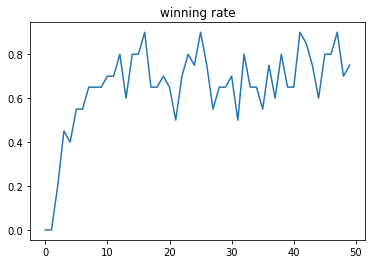

In [25]:
from matplotlib import pylab as plt
%matplotlib inline

episodes_rewards = np.array(episodes_rewards)
episodes_rewards_mean = episodes_rewards.reshape([-1, 20]).mean(axis=1)


# plt.hist(episodes_rewards)
plt.figure()
plt.plot(episodes_rewards_mean)
print(episodes_rewards_mean)
plt.title('winning rate')

## deployment

In [35]:
play_episode_num = 3
success_num = 0

for episode in range(play_episode_num):
    state = env.reset()
    done = False
    
    print('***Episode {}***'.format(episode))
    time.sleep(1)
    clear_output(wait=True)
    for step in range(timeout_step_num):
        env.render()
        time.sleep(0.3)
        clear_output(wait=True)
        action = np.argmax(q_table[state, :])
        new_state, reward, done, _ = env.step(action)
        if done:
            env.render()
            if reward == 1:
                print('Goal Reached!')
                success_num += 1
            else:
                print('Agent Failed!')
            time.sleep(3)
            clear_output(wait=True)
            break
        else:
            state = new_state

print('Success {} out of {}'.format(success_num, play_episode_num))

Success 7 out of 10
